# Assignment 2: Reinforcement Learning
## Implementation of an Atari Breakout RL Agent using a Double Deep Q Network

Team memebers: Bryan Carty (19235836) & Eoin Chedzey (18223796)<br>
This code executes all the way through, without an error.<br>
Our code is based on the Atari Breakout implementation in the book 'Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow' by Aurélien Géron. The jupyter notebook covering the reinforcement learning chapter can be found at: https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb

With the exception of a few hyperparameters, the hyperparameters we found to be optimal correspond to those outlined in the 'Human-level control through deep reinforcement learning' paper by DeepMind in 2015. It can be found at: https://www.nature.com/articles/nature14236?wm=book_wap_0005<br><br><br>

### Double DQN Implementation

**Imports**

In [1]:
from tf_agents.environments import suite_atari # Suite for loading Atari Gym environments
from tf_agents.environments.atari_preprocessing import AtariPreprocessing # Does the same preprocessing as was done on Nature's 2015 DQN paper
from tf_agents.environments.atari_wrappers import FrameStack4 # Stacks previous 4 frames
import tensorflow as tf
import numpy as np
import tempfile
import os
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
print(tempdir)

2022-12-16 11:59:14.935980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-12-16 11:59:14.936139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-12-16 11:59:14.936148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


/tmp


**Constants**

In [2]:
max_episode_steps = 27000 # 4 frames per step, so a max of 108k frames per episode
environment_name = "BreakoutNoFrameskip-v4" # Environment does not have frame skipping by default

**Custom class to perform preprocessing on Atari Breakout Frames**

In [3]:
class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action) # done is true when a life is lost and terminal_on_life_loss, or when the episode is over.
        if self.ale.lives() < lives_before_action and not done: 
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

**Load Atari Breakout Environment (wrapped with preprocessing and framestacking)**

In [4]:
env = suite_atari.load( 
    environment_name, # Load a wrapped BreakoutNoFrameskip environment, with a max of 27,000 steps per episode.
    max_episode_steps=max_episode_steps, # AtariPreprocessing wrapper implements same preprocessing done in 2015 DQN paper e.g. convert to greyscale, scale to 84 x 84 pixels, implement frame skipping (4 frames). Hover over AtariPreprocessing to see the rest.
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4] # In addition to frame skipping, these skipped frames are stacked, one on top of another (deciphers velocity). Stack size = 4.
)

**Display what preprocessed observation looks like**

Saving figure preprocessed_breakout_observation_plot


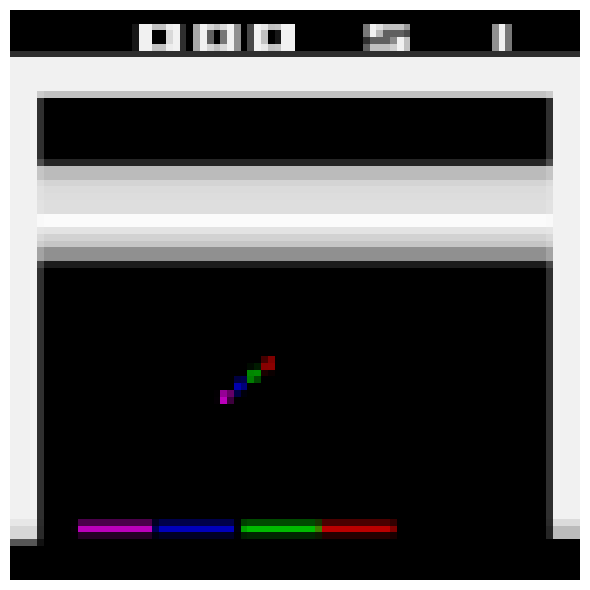

In [5]:
import matplotlib.pyplot as plt

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("images", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

env.seed(42)
env.reset()
for _ in range(4): # 4 as 4 frames are stacked together
    time_step = env.step(3) # Move left

def plot_observation(obs): # function to plot observation
    # red = 3 time steps ago
    # green = 2 time steps ago
    # blue = previous frame
    # purple = current frame
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_observation_plot")
plt.show()

**Wrap the environment inside a TFPyEnvironment.**

In [10]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
tf_env = TFPyEnvironment(env) # We wrap the environment inside a TFPyEnvironment. This will make the environment usable within a Tensorflow graph.

**Create Q Network**

In [11]:
from tf_agents.networks.q_network import QNetwork # Q Network -> takes an observation as input and outputs 1 Q-Value per action.
preprocessing_layer = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32)/255.) # This layer casts the observations to 32 bit floats and normalizes them (values will range from 0.0 -> 1.0)
conv_layer_params = [(32, (8,8), 4), (64, (4,4), 2), (64, (3,3), 1)] # 3 convolution layers -> a layer being (num filters, (filter dimensions), stride)
fc_layer_params = [512] # a dense layer with 512 units. This layer is followed by a dense layer with 4 units -> 1 per action. Outputs Q value.
                    # input tensor spec, action tensor spec, preprocessing layer, conv layer, fully connected layer params.
q_net = QNetwork(tf_env.observation_spec(), tf_env.action_spec(), preprocessing_layers=preprocessing_layer, conv_layer_params=conv_layer_params, fc_layer_params=fc_layer_params, kernel_initializer=tf.initializers.glorot_uniform)


**Create and initialize DQN Agent**

In [12]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent # Implements the DQN algorithm from "Human level control through deep reinforcement learning" Mnih et al., 2015
train_step = tf.Variable(0) # counts the number of training steps
update_period = 4 # train the model every 4 steps
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True) # same hyperparameters as in 2015 DQN paper.
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay( # will compute epsilon for a given training step. Will go from 1.0 to 0.001. The value used in 2015 DQN paper is 1,000,000 frames so 250,000 steps. But since we're training every 4 steps (16 frames), we'll decay over 62,500 training steps
    initial_learning_rate=1.0,
    decay_steps= 250000 // update_period, # number of decay steps # 1,000,000 ALE frames  # // Performs floor-division on the values on either side. Then assigns it to the expression on the left.
    end_learning_rate=0.01
)
agent = DqnAgent( # Creates a DQN Agent
    tf_env.time_step_spec(), 
    tf_env.action_spec(), 
    q_network=q_net, 
    optimizer=optimizer, 
    target_update_period=2000, # Period for soft update of the target networks. 2000 x 4 = 8000, 8000 x 4 = 32,000 ALE Frames.
    td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"), # The Huber loss function can be used to balance between the Mean Absolute Error and the Mean Squared Error. It is therefore a good loss function for when you have varied data or only a few outliers. Reduction is none so it returns error per instance not the mean error.
    gamma=0.99, # discount factor
    train_step_counter=train_step, # counts number of training steps
    epsilon_greedy=lambda: epsilon_fn(train_step) # function to compute epsilon for a given training step.
)
agent.initialize() # initialize the agent

**Create replay buffer**

In [13]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer # A batched replay buffer of nests of Tensors which can be sampled uniformly. Would like to implement a prioritized experience replay buffer if time permits.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, # specification of the data saved in the replay buffer.(trajectory spec) The DQN agent knows what the collected data looks like
    batch_size=tf_env.batch_size, # In our case it's 1.
    max_length=400000 # max size of the replay buffer -> This will require a lot of RAM.
)

2022-12-16 12:11:41.355061: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 11289600000 exceeds 10% of free system memory.


**Create observer that writes trajectories to the replay buffer**

In [14]:
replay_buffer_observer = replay_buffer.add_batch # an observer that writes trajectorys to the replay buffer.

**Create a custom observer to count the steps**

In [15]:
class ShowProgress: # custom observer to count steps. 
    def __init__(self, total):
        self.counter=0
        self.total=total
    def __call__(self, trajectory):
        if not trajectory.is_boundary:
            self.counter+=1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

**Prepare for metric logging**

In [16]:
from tf_agents.metrics import tf_metrics 
train_metrics = [ # metrics
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),#counts undiscounted rewards
    tf_metrics.AverageEpisodeLengthMetric(),
]

from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)

**Create main driver**

In [17]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver 
collect_driver = DynamicStepDriver(
    tf_env, # interact with this env
    agent.collect_policy, # using this policy
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period # The number of steps to take in the environment. Collect 4 steps for each training iteration.
)

**Create driver to initialize replay buffer with transitions**

In [18]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env, 
    initial_collect_policy, 
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000 # 80,000 ALE frames
)

**initialize replay buffer with transitions**

In [19]:
final_time_step, final_Policy_state = init_driver.run()

0/20000

**Sample 2 sub episodes from the replay buffer - 3 timesteps each**

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Saving figure sub_episodes_plot


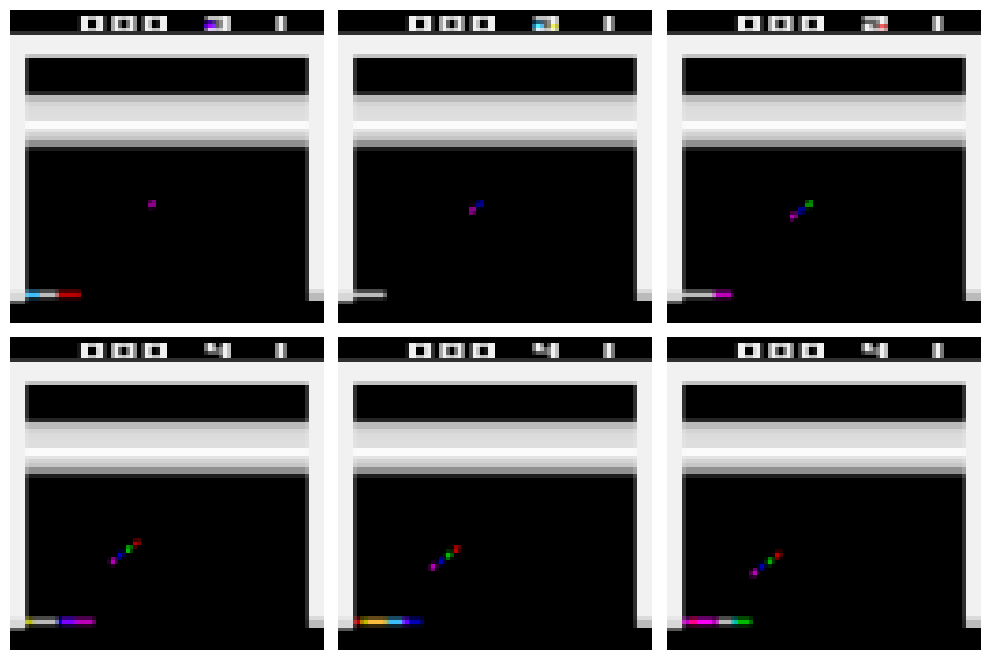

In [20]:
tf.random.set_seed(3) 
trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

**Create dataset from replay buffer**

In [21]:
dataset = replay_buffer.as_dataset( # for our main loop, instead of calling the get_next() method, we use a tf.data.Dataset so we can benefit from parallelism and prefetching.
    sample_batch_size=64, # We sample 64 trajectories at each training step (2015 DQN paper), each with 2 steps, e.g. 1 full transition.
    num_steps=2,
    num_parallel_calls=3 # This dataset willprocess 3 elements in parallel, and prefetch 3 batches.
).prefetch(3) # While the model is executing training step s , the input pipeline is reading the data for step s+1 . Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.


**Convert main functions to tensorflow functions**

In [22]:
from tf_agents.utils.common import function
collect_driver.run = function(collect_driver.run) # convert main functions to tensorflow functions for performance benefits.
agent.train = function(agent.train)

**Define functions to record video**

In [23]:
import matplotlib.animation as animation
import PIL
frames = []

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def save_frames(trajectory):
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

def record_video(name):
    watch_driver = DynamicStepDriver(
        tf_env,
        agent.policy,
        observers=[save_frames, ShowProgress(1000)],
        num_steps=10000)
    final_time_step, final_policy_state = watch_driver.run()
    plot_animation()
    video_path = os.path.join("videos", "rl", str(name)+".gif")
    frame_images = [PIL.Image.fromarray(frame) for frame in frames[:len(frames)]]
    frame_images[0].save(video_path, format='GIF',
                        append_images=frame_images[1:],
                        save_all=True,
                        duration=30)
    frames.clear()




In [24]:
#Checkpointer
from tf_agents.utils import common
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step
)


INFO:absl:No checkpoint available at /tmp/checkpoint


In [25]:
print(train_step)
print(tempdir)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
/tmp


In [26]:
#Policy Saver
from tf_agents.policies import policy_saver
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

**Define function to train agent**

In [27]:
rewards = []
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size) # returns a nested object of type policy_state containing properly initialized Tensors.
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)
            reward = train_metrics[2].result().numpy().astype(float)
            rewards.append(reward)
        if iteration % 100000 == 0:
            record_video("breakout-iter-"+str(iteration))
            train_checkpointer.save(train_step)
        if iteration % 1000000 == 0:
            tf_policy_saver.save(policy_dir)



**train agent**

In [ ]:
num_iterations = 8000000
train_agent(n_iterations=num_iterations)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2022-12-16 12:21:03.959759: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc694042a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-16 12:21:03.959809: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2022-12-16 12:21:03.991570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-16 12:21:04.271209: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentS

0/1000:0.00030

/home/ubuntu/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
INFO:absl:Saved checkpoint: /tmp/checkpoint/ckpt-1
/home/ubuntu/anaconda3/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


0/1000 loss:0.01156

/home/ubuntu/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


119298 loss:0.00055

### Visualize Double DQN Performance

**Record final video of performance**

In [22]:
record_video("breakout-final")

0/1000

**Plot reward per episode**

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, len(rewards)).tolist(), rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Average reward received", fontsize=14)
save_fig("double_dqn_reward_plot")
plt.show()


NameError: name 'rewards' is not defined

<Figure size 800x400 with 0 Axes>

Saving figure double_dqn_reward_plot


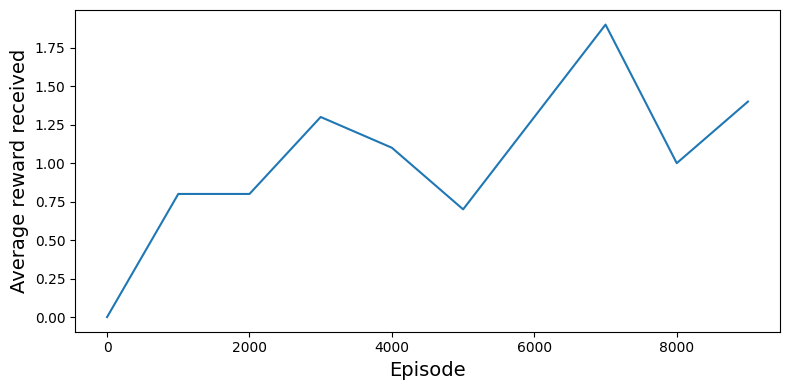

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, num_iterations, 1000).tolist(), rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Average reward received", fontsize=14)
save_fig("double_dqn_reward_plot")
plt.show()
